In [1]:
import pandas as pd
import numpy as np
import os
import itertools
from matplotlib import pyplot as plt 
import networkx as nx
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime
import ast 

'C:\\Users\\zogaj\\PycharmProjects\\MA\\ExperimentLogs'

##### recipe 
1. create or load tabular data 
2. select important features for linking observations together 
3. permute all combinations in a long format (1,2), (1,3),...,(1,n), (2,3), ...(n-1,n)
- The long_df becomes even longer for directed connections 
4. compute similarity variables 
- for numeric, simply subtract 
- for categories (check for equality) 
- possibly add interactions or more complex measures (like specific functions)
5. specify a linear relationship and a GLM link function 

 

#### Drawbacks of GLM approachs: 

"*A typical solution involves hand-engineering domain-specific features based on expert
knowledge. Even if one discounts the tedious effort required for
feature engineering, such features are usually designed for specific
tasks and do not generalize across different prediction tasks.*" 

- from word2vec paper

In [2]:
# https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries?select=ds_salaries.csv
salaries = pd.read_csv(r"Data/ds_salaries.csv")
salaries = salaries.drop(columns=["Unnamed: 0", "work_year", "employment_type",
                                  "salary", "salary_currency",])#.sample(n=100, random_state=32)
salaries

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,79833,DE,0,DE,L
1,SE,Machine Learning Scientist,260000,JP,0,JP,S
2,SE,Big Data Engineer,109024,GB,50,GB,M
3,MI,Product Data Analyst,20000,HN,0,HN,S
4,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...
602,SE,Data Engineer,154000,US,100,US,M
603,SE,Data Engineer,126000,US,100,US,M
604,SE,Data Analyst,129000,US,0,US,M
605,SE,Data Analyst,150000,US,100,US,M


### Manipulate Data:

In [3]:
np.random.seed(26)
scaler = StandardScaler()
salaries['salary_in_usd'] = scaler.fit_transform(salaries[['salary_in_usd']]) #maybe log?
#salaries.salary_in_usd.hist(bins = 20)

# Omit countries with low frequency observations 
class_counts = salaries['employee_residence'].value_counts()
salaries = salaries[salaries['employee_residence'].isin(class_counts[class_counts >= 7].index)]

# Omit 100 random us citizens for better group balance 
condition = (salaries['employee_residence'] == "US")
indices_to_remove = salaries[condition].index
indices_to_remove_random = np.random.choice(indices_to_remove, size=282, replace=False)
salaries = salaries.drop(indices_to_remove_random)
salaries


,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,-0.457904,DE,0,DE,L
1,SE,Machine Learning Scientist,2.083282,JP,0,JP,S
2,SE,Big Data Engineer,-0.046177,GB,50,GB,M
10,EN,Data Scientist,-0.860055,FR,0,FR,S
11,MI,Data Scientist,-1.012949,IN,0,IN,L
...,...,...,...,...,...,...,...
600,EN,Data Analyst,-0.638909,CA,0,CA,M
601,EN,Data Analyst,-0.850478,CA,0,CA,M
602,SE,Data Engineer,0.588192,US,100,US,M
605,SE,Data Analyst,0.531774,US,100,US,M


#### Connenction Permutation 

\begin{equation}
C(n, 2) = \frac{{n \cdot (n - 1)}}{2}
\end{equation}
possible Connections

In [4]:
n_permutes = lambda n : int((n * (n-1)) / 2)
print(n_permutes(salaries.shape[0]))

26565


In [5]:
idx_pairs = list(itertools.combinations(salaries.index, 2))

salary_pairs = list(itertools.combinations(salaries.salary_in_usd, 2))
salary_delta = [abs(pair[0] - pair[1]) for pair in salary_pairs]

residence_pairs = list(itertools.combinations(salaries.employee_residence, 2))
fellow_country = [int(pair[0] == pair[1] )for pair in residence_pairs]

experience_pairs = list(itertools.combinations(salaries.experience_level, 2))
same_experience = [int(pair[0] == pair[1] )for pair in experience_pairs]

title_pairs = list(itertools.combinations(salaries.job_title, 2))
same_title = [int(pair[0] == pair[1] )for pair in title_pairs]

df_long = pd.DataFrame({'idx': idx_pairs, 
                   'wage_delta': salary_delta,
                   'fellow_country': fellow_country, 
                   'same_title': same_title, 
                   'same_experience': same_experience
                   })

In [6]:
df_long

,idx,wage_delta,fellow_country,same_title,same_experience
0,"(0, 1)",2.541186,0,0,0
1,"(0, 2)",0.411728,0,0,0
2,"(0, 10)",0.402151,0,1,0
3,"(0, 11)",0.555045,0,1,1
4,"(0, 12)",0.563014,0,1,0
...,...,...,...,...,...
26560,"(601, 605)",1.382252,0,1,0
26561,"(601, 606)",2.087483,0,0,0
26562,"(602, 605)",0.056418,1,0,1
26563,"(602, 606)",0.648812,0,0,0


Generate Conditional Probabilities based on similarity of observations. 

\begin{equation}
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_{1}x_{1} + \beta_{2}x_{2} + \ldots + \beta_nx_n)}}
\end{equation}

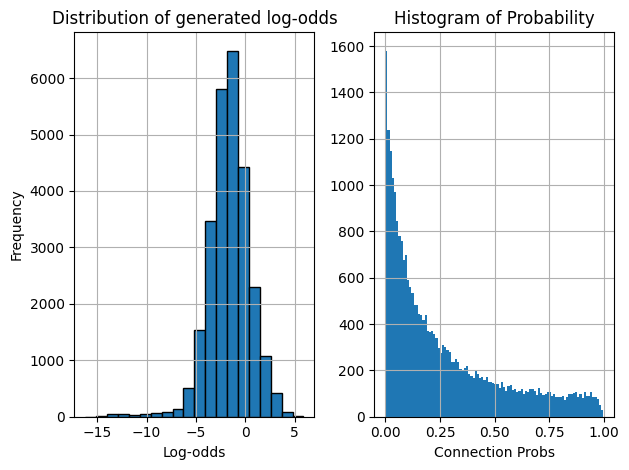

In [7]:
np.random.seed(26)
# A low negative intercept means a low default connection probability (all else = 0)
# Pushing it extremely low, will cause no connections 
beta_0 = -1
# Coefficient for countrymen, 1 -> making it more likely to connect 
beta_cm = np.log(10)  # increase the odds-ratio by _(whats inside the log)
# Coefficient for wagedelta: the larger the gap, the less likely a connection happens 
beta_wd = -1.5 
# Coefficient for same experience: 1 -> making it more likely to connect 
beta_exper = np.log(2) 

beta_ti = np.log(4) 

log_odds = (beta_0 +
            beta_cm * df_long.fellow_country + 
            beta_wd * df_long.wage_delta +
            beta_ti * df_long.same_title +
            beta_exper * df_long.same_experience +
            np.random.normal(0,1,df_long.shape[0])) 
# Changes shape of distribution, larger variance -> clearer bounds
# Can break indented structure harshly when too high 

df_long["Connection_Prob"] = 1 / (1 + np.exp(-log_odds))

plt.subplot(1, 2, 1)
plt.hist(log_odds, bins= 20, edgecolor='black')
plt.title("Distribution of generated log-odds")
plt.xlabel('Log-odds')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
df_long["Connection_Prob"].hist(bins=100)
plt.title('Histogram of Probability')
plt.xlabel('Connection Probs')

plt.tight_layout()
plt.show()

<Axes: xlabel='wage_delta', ylabel='Connection_Prob'>

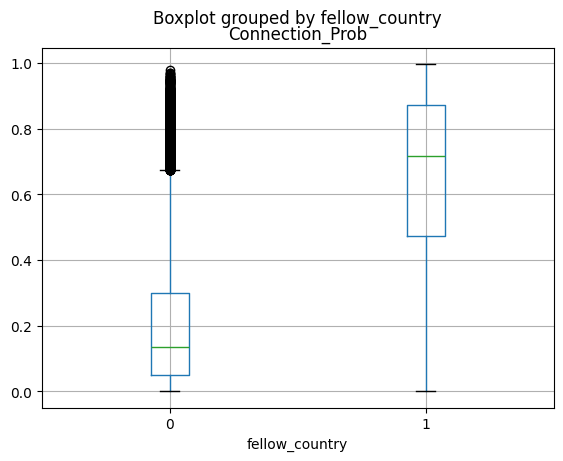

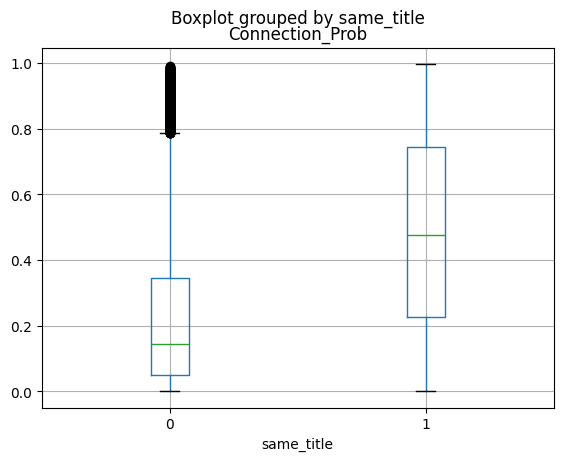

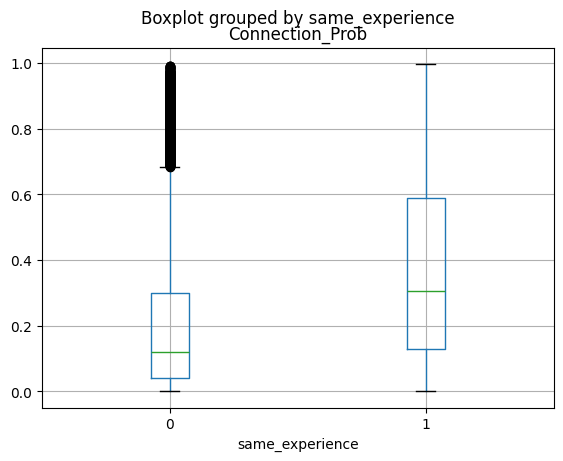

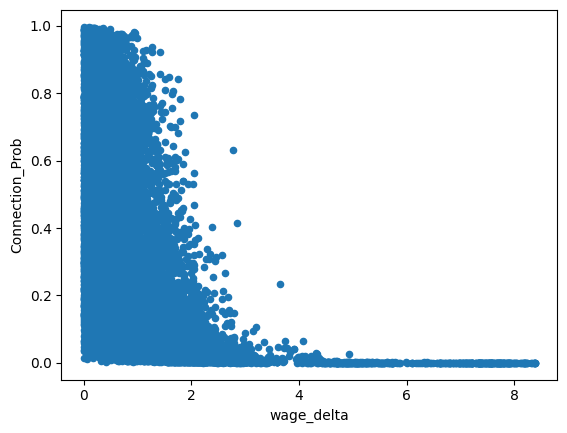

In [8]:
df_long.boxplot(column = ["Connection_Prob"],
           by = "fellow_country")

df_long.boxplot(column = ["Connection_Prob"],
           by = "same_title")

df_long.boxplot(column = ["Connection_Prob"],
           by = "same_experience")

df_long.plot(kind='scatter',
         x='wage_delta', y="Connection_Prob")


In [9]:
countries = salaries.employee_residence.unique()
color_map = dict(zip(countries,
     np.arange(len(countries))))
country_to_color = lambda x : color_map[x]

G = nx.Graph()
G.add_nodes_from(salaries.index,
                 size = salaries.salary_in_usd)

G.add_edges_from(df_long[df_long['Connection_Prob'] > 
                      np.random.uniform(0.1,1.1,
                                        df_long.shape[0])]['idx']
                      )

print(nx.adjacency_matrix(G).toarray())
print("Number of nodes in G:", nx.number_of_nodes(G))
print("Avg. degree in G:",sum(dict(G.degree()).values()) / len(G))
# print("Avg. shortest path:", nx.average_shortest_path_length(G))
#print(salaries.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Number of nodes in G: 231
Avg. degree in G: 42.935064935064936


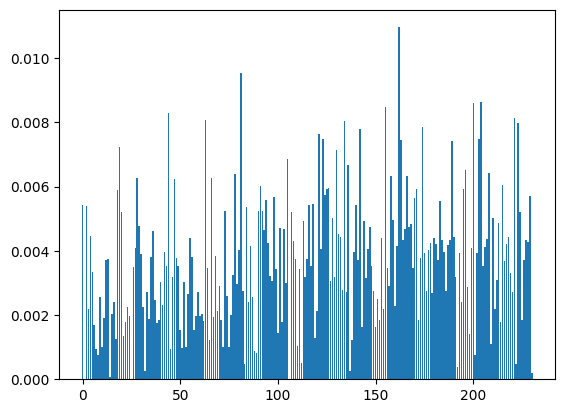

dict_values([64, 4, 52, 43, 53, 50, 34, 28, 26, 42, 26, 38, 50, 46, 8, 32, 45, 27, 66, 55, 54, 29, 25, 41, 30, 2, 45, 51, 51, 60, 52, 39, 9, 47, 36, 44, 62, 39, 37, 33, 45, 37, 45, 44, 71, 13, 45, 48, 49, 49, 34, 25, 31, 33, 33, 37, 50, 32, 35, 45, 40, 39, 31, 57, 40, 20, 57, 30, 41, 25, 51, 36, 29, 56, 48, 25, 33, 43, 47, 36, 41, 53, 47, 24, 55, 37, 45, 37, 29, 25, 55, 61, 59, 65, 57, 51, 40, 36, 52, 49, 30, 49, 32, 60, 47, 55, 0, 54, 44, 30, 19, 35, 17, 49, 47, 42, 50, 40, 51, 30, 35, 45, 47, 51, 46, 60, 53, 45, 60, 53, 72, 60, 55, 40, 49, 34, 51, 17, 26, 42, 49, 52, 65, 24, 44, 38, 47, 44, 42, 29, 36, 39, 28, 43, 36, 53, 39, 42, 50, 52, 44, 43, 64, 51, 54, 62, 66, 62, 53, 46, 66, 69, 33, 49, 51, 52, 44, 47, 52, 40, 54, 57, 44, 60, 31, 52, 43, 52, 57, 35, 47, 48, 11, 41, 38, 45, 55, 46, 22, 42, 55, 23, 33, 65, 64, 42, 45, 43, 61, 31, 40, 41, 47, 57, 36, 59, 51, 32, 51, 22, 38, 55, 20, 49, 60, 32, 45, 43, 43, 47, 8])

In [10]:
# The betweenness centrality for each vertex is the number of shortest paths that pass through the vertex.
# Makes little sense for this example, might be more interesting for spatial Graphs, like traffic networks. 

betweenness = nx.betweenness_centrality(G)

#for node, centrality in betweenness.items():
#    print("Node:", node, "Centrality:", centrality)

scores = [centrality for node, centrality in betweenness.items()]
plt.bar(range(len(scores)), scores)
plt.show()

# calculate scores for synthetically recreated graph (s times) and plot with conf.ints
# Nodes must be same for all graphs 

# Same could be done with node degrees 
dict(G.degree()).values()

C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


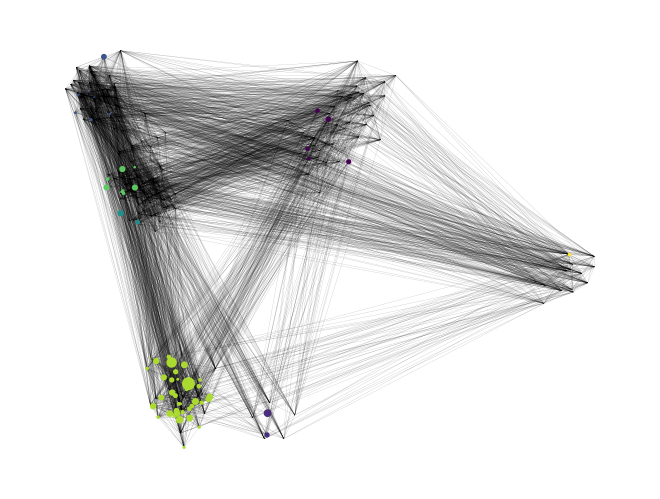

In [11]:
def gen_position(intra_spread, inter_spread): 
    np.random.seed(26)
    mu_y = np.random.normal(0,inter_spread,len(countries)) #linspace(-10,10,len(countries))  
    mu_x = np.random.normal(0,inter_spread,len(countries)) #linspace(-10,10,len(countries))  
    
    cc = (pd.DataFrame(np.array([countries, mu_x, mu_y]).T).
                         set_index(0).apply(tuple, axis=1).to_dict())
    
    position = {index: cc[row['employee_residence']] + np.random.normal(0,intra_spread,2)
     for index, row in salaries.iterrows()}
    
    return position

nx.draw(G, with_labels = False, 
        node_size = salaries.salary_in_usd * 10,
        pos = gen_position(1, 7), 
        node_color = salaries.employee_residence.apply(country_to_color), 
        width = 0.05, alpha = 0.99)


## Learn Connections with GLMS 

In [16]:
# from sklearn.preprocessing import FunctionTransformer

df_long["Target"] = (df_long.Connection_Prob > 
                     np.random.uniform(0.5,1,df_long.shape[0]))
# log_transform = lambda x : np.log(x)

X = df_long.drop(['Target',
             "idx",
             #'fellow_country',
             "Connection_Prob"], axis=1)
y = df_long['Target']

numeric_features = ['wage_delta']
categorical_features = ['same_title',
                        'fellow_country',
                        'same_experience']

numeric_transformer = Pipeline(steps=[
    #('log_transformer', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessing and logistic regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

predictions = pipeline.predict(X_test)


Accuracy: 0.924901185770751


#### Learn diffrent edge types (soft-max-regression) or strength (linear regression with output constraints) 